In [1]:
import glob
import numpy as np
import scipy.io

In [2]:
# from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mplplt
import numpy as np
import pyemma

import pyemma.coordinates as coor
import pyemma.plots as mplt
#%pylab inline
%matplotlib inline
from pyemma.util.contexts import settings

In [3]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mplplt
import numpy as np
import pyemma

import pyemma.coordinates as coor
import pyemma.plots as mplt
#%pylab inline
%matplotlib inline

### Load Data

In [4]:
import numpy as np
test=np.loadtxt("./msm/sample_L70_rho3_0.txt")
print(len(test))

# time identity distance inter intra
data_log = []

for directory in glob.glob("./msm",recursive=True):
    print("Directory",directory)
    
    pathname=directory+"/sample_*rho*_*.txt"
    count = 0 
    for file in glob.glob(pathname):
        count = count + 1 
        inp_raw = np.loadtxt(file, usecols = (3,2), skiprows=0)
        #print(inp_raw.T.shape)
        
        inp_log = np.zeros((len(test),2))
        for i in range(len(test)):
            inp_log.T[0][i] = inp_raw.T[0][i]
            inp_log.T[1][i] = inp_raw.T[1][i]*0.1 
            
        data_log.append(inp_log)
print(count)

9003
Directory ./msm
268


In [5]:
DataConc=np.concatenate(data_log)

In [6]:
DataConc.shape

(2412804, 2)

In [7]:
np.save("DataConc",DataConc)

In [8]:
DataConc=np.load("DataConc.npy")
DataConc.shape

(2412804, 2)

### Plot Feature Histogram

In [9]:
# Plots setup 
from matplotlib import rc
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans", 
    "font.serif": ["computer modern roman"],
    "font.size": 16})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

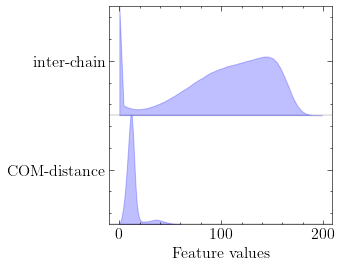

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))
pyemma.plots.plot_feature_histograms(DataConc,ax=ax,feature_labels=[
                                                              'inter-chain',
                                                             'COM-distance']);
fig.tight_layout()
#fig.savefig('./CV_plt.png',dpi=100)

In [11]:
DataConc.shape

(2412804, 2)

In [12]:
DataConc_select=DataConc[:,[0, 1]]
DataConc_select.shape

(2412804, 2)

### Discretize CV space

In [13]:
#k-means clustering
cluster = pyemma.coordinates.cluster_kmeans(
    DataConc_select, k=100, max_iter=100, stride=10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

In [14]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=100, count_mode='effective',dt_traj='0.1 ns')

100

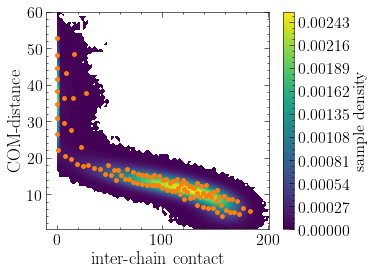

In [15]:
fig, ax = plt.subplots()
pyemma.plots.plot_density(*DataConc_select.T, ax=ax, cbar=True, alpha=1);
ax.scatter(*cluster.clustercenters.T, s=15, c='C1');
ax.set_xlabel('inter-chain contact',fontsize=18);
ax.set_ylabel('COM-distance',fontsize=18);
#ax.set_xlim(0, 6.5);
#ax.set_ylim(0, 6.5);
#plt.plot(nn,nn, linestyle='dashed',c='k',linewidth=plw)
#plt.savefig('Discretization.png', dpi=200, bbox_inches='tight')

np.size(msm.active_set)

### Lagtime validation for the slowest implied timescale

In [16]:
its = pyemma.msm.its(cluster.dtrajs, lags=[1,5,10,20,30,50,75,100,125], nits=4, errors='bayes')

estimating BayesianMSM:   0%|                                                                                 …

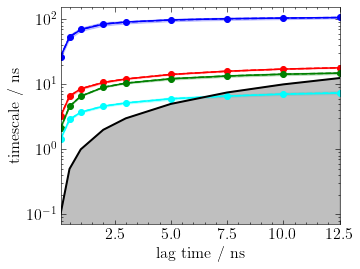

In [17]:
pyemma.plots.plot_implied_timescales(its, ylog=True, units='ns', dt=0.1);
#plt.savefig('ImpliedTiemscalesLag.png', dpi=200, bbox_inches='tight')

# NSTATES

In [18]:
nstates = 2

The first eigenvector is one: True (min=0.9999999999999966, max=1.0000000000000058)


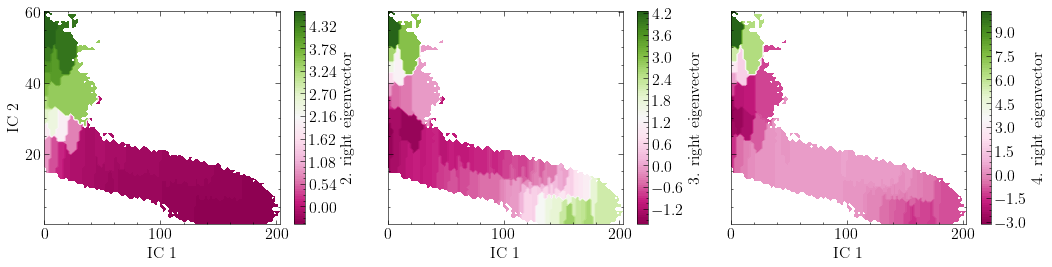

In [19]:
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *DataConc_select.T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In [20]:
msm.pcca(nstates)

PCCA(P=array([[1.89032e-02, 3.84747e-03, ..., 9.11545e-06, 1.07450e-02],
       [9.93620e-03, 8.29974e-03, ..., 8.17130e-04, 1.69287e-02],
       ...,
       [1.24846e-05, 4.33352e-04, ..., 1.75347e-01, 6.32173e-06],
       [1.14222e-02, 6.96825e-03, ..., 4.90666e-06, 1.56667e-02]]),
   m=2)

estimating MaximumLikelihoodMSM:   0%|                                                                        …

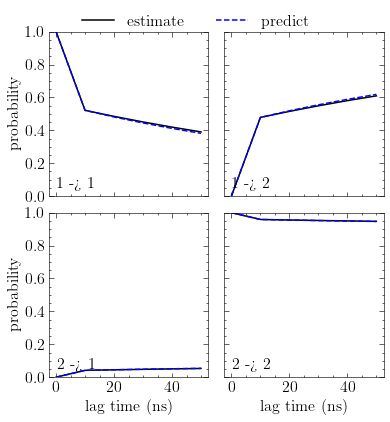

In [21]:
cktest = msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');

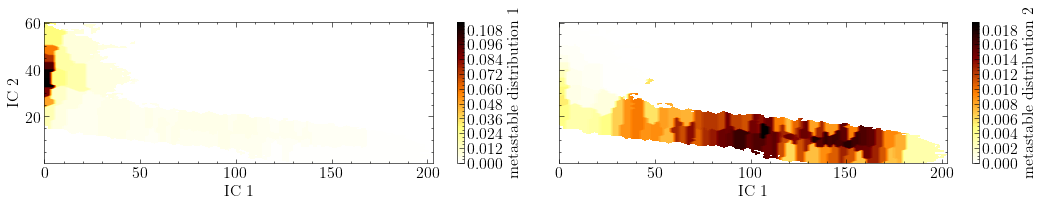

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *DataConc_select.T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In [23]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

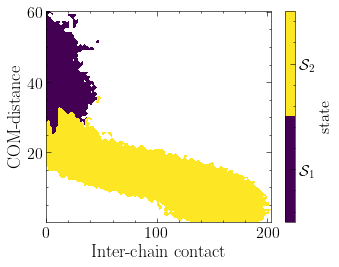

In [24]:
#metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *DataConc_select.T, metastable_traj, ax=ax)

#ax.set_xlim(0,6)
#ax.set_ylim(0,10)
ax.set_ylabel('COM-distance',fontsize=18);
ax.set_xlabel('Inter-chain contact',fontsize=18);
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
#plt.axvline(3.4,color = 'cyan',linewidth=2, linestyle = "--")
#plt.axvline(2.7,color = 'cyan',linewidth=2, linestyle = "--")
#plt.savefig('MSM.png', dpi=600, bbox_inches='tight')
#################################
#################################

### Timescales with confidence interval, using Bayesian MSM

In [25]:
timescales= msm.timescales(1)

bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=100, 
                                                conf=0.95, 
                                                count_mode='effective', 
                                                dt_traj='0.1 ns',mincount_connectivity=1E-10)
sample_mean = bayesian_msm.sample_mean('timescales', k=1)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=1)

print('ITS from Markov Model:',timescales[0])
print('Mean of first ITS: {:f}'.format(sample_mean[0]))
print('Confidence interval: [{:f}, {:f}]'.format(sample_conf_l[0], sample_conf_r[0]))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[7]: compute stat. inefficiencies:   0%|                        …

pyemma.msm.estimators.bayesian_msm.BayesianMSM[7]: Sampling MSMs:   0%|                                       …

ITS from Markov Model: 105.07685722430898
Mean of first ITS: 105.300604
Confidence interval: [101.442669, 109.749660]


In [26]:
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

fraction of states used = 1.00
fraction of counts used = 1.00


In [27]:
print(nstates)

2


estimating BayesianMSM:   0%|                                                                                 …

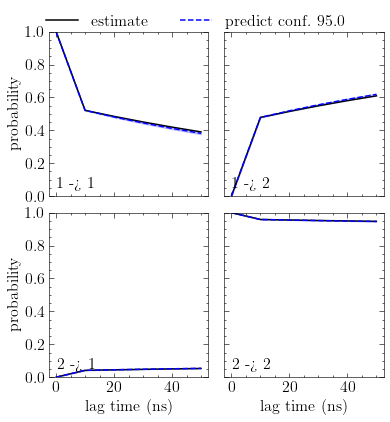

In [28]:
bayesian_cktest = bayesian_msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(bayesian_cktest, dt=0.1, units='ns');

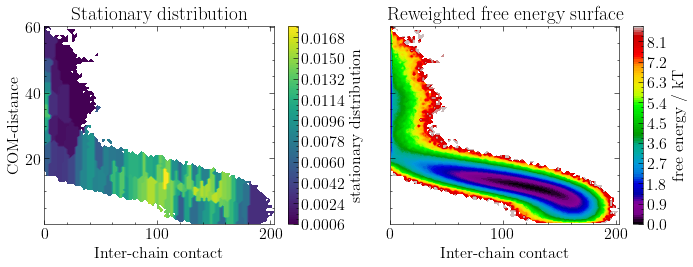

In [29]:
#The FES is not too relevant because each data point is one chain in one timestep 
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *DataConc_select.T,
    bayesian_msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *DataConc_select.T,
    weights=np.concatenate(bayesian_msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('Inter-chain contact')
axes[0].set_ylabel('COM-distance')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

The first eigenvector is one: True (min=0.9999999999999966, max=1.0000000000000058)


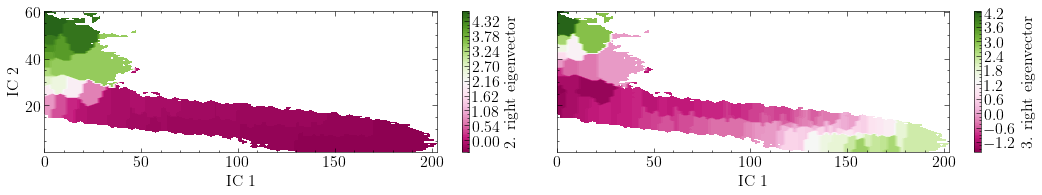

In [30]:
eigvec = bayesian_msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *DataConc_select.T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In [31]:
bayesian_msm.pcca(nstates)

PCCA(P=array([[1.89032e-02, 3.84747e-03, ..., 9.11545e-06, 1.07450e-02],
       [9.93620e-03, 8.29974e-03, ..., 8.17130e-04, 1.69287e-02],
       ...,
       [1.24846e-05, 4.33352e-04, ..., 1.75347e-01, 6.32173e-06],
       [1.14222e-02, 6.96825e-03, ..., 4.90666e-06, 1.56667e-02]]),
   m=2)

In [32]:
bayesian_msm.active_set.shape

(100,)

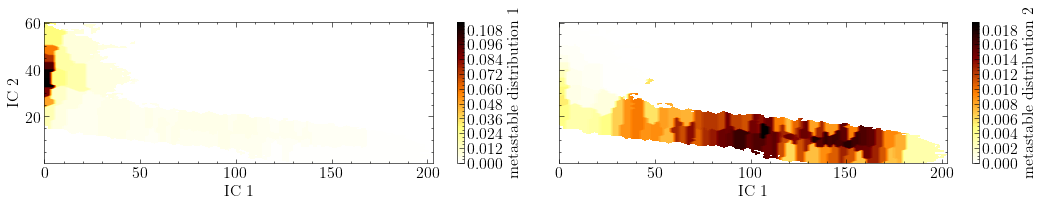

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *DataConc_select.T,
        bayesian_msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

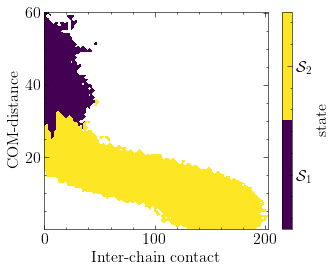

In [34]:
bayesian_metastable_traj = bayesian_msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *DataConc_select.T, bayesian_metastable_traj, ax=ax)
ax.set_ylabel('COM-distance')
ax.set_xlabel('Inter-chain contact')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
#plt.axvline(3,color = 'cyan',linewidth=2, linestyle = "--")
#plt.axvline(3.4,color = 'cyan',linewidth=2, linestyle = "--")
#plt.axvline(2.7,color = 'cyan',linewidth=2, linestyle = "--")
#plt.savefig('MSM_bayesian.png', dpi=600, bbox_inches='tight')

### Committor Analysis 

In [35]:
bayesian_msm.active_set.shape

(100,)

In [36]:
#print(nstates)
#bayesian_msm.pcca(nstates)
for i, s in enumerate(bayesian_msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, bayesian_msm.pi[s].sum()))
    
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = bayesian_msm.mfpt(
            bayesian_msm.metastable_sets[i],
            bayesian_msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

π_1 = 0.068105
π_2 = 0.931895
MFPT / steps:


,1,2
1,0.00,77.91
2,1333.38,0.00


In [37]:
bayesian_metastable_traj = bayesian_msm.metastable_assignments[dtrajs_concatenated]
highest_membership = bayesian_msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[bayesian_msm.active_set[highest_membership]]

In [38]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = bayesian_msm.mfpt(
            bayesian_msm.metastable_sets[i],
            bayesian_msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

In [39]:
inverse_mfpt

array([[0.        , 0.012835  ],
       [0.00074997, 0.        ]])

In [40]:
print(np.max(DataConc_select.T[0]))
print(np.min(DataConc_select.T[0]))

202.828569
0.0


In [41]:
print(np.max(DataConc_select.T[1]))
print(np.min(DataConc_select.T[1]))

60.3347228
0.11827140000000001


In [42]:
coarse_state_centers

array([[  0.20800498,  34.791603  ],
       [107.1795    ,  13.128451  ]], dtype=float32)

In [43]:
coarse_state_centers.shape

(2, 2)

In [44]:
arrays1 = np.array([1.4964094, 4.9101458],dtype=float)
arrays2 = np.array([3.0579512, 4.6915975],dtype=float)
arrays3 = np.array([3.7223663, 1.7115642],dtype=float)
arrays = np.array([arrays1,arrays2,arrays3],dtype=float)

In [45]:
arrays.shape

(3, 2)

In [46]:
arrays

array([[1.4964094, 4.9101458],
       [3.0579512, 4.6915975],
       [3.7223663, 1.7115642]])

In [47]:
mfpt

array([[   0.        ,   77.91197889],
       [1333.38117961,    0.        ]])

In [48]:
inverse_mfpt

array([[0.        , 0.012835  ],
       [0.00074997, 0.        ]])

In [49]:
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

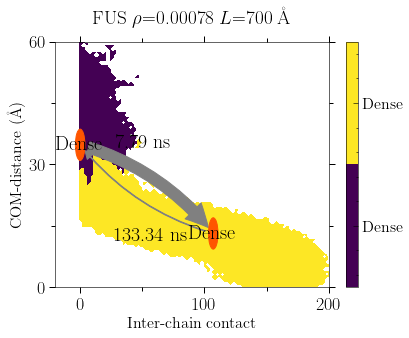

In [50]:
fig, ax = plt.subplots(figsize=(6, 5))

_, _, misc = pyemma.plots.plot_state_map(
    *DataConc_select.T, bayesian_metastable_traj, ax=ax, zorder=-1, cbar_label=None,)
misc['cbar'].set_ticklabels(range(1, nstates+1))  # set state numbers 1 ... nstates

_, pos = pyemma.plots.plot_network(
    inverse_mfpt,
    #state_sizes=state_size,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.2f ns',
    arrow_labels=mfpt*0.1,
    size=20,
    arrow_curvature=3,
    state_labels=["Dense","Dense"],
    show_frame=True,
    ax=ax)
misc['cbar'].set_ticklabels(["Dense","Dense"])

ax.set_ylabel(r'COM-distance ($\mathrm{\AA}$)')
ax.set_xlabel('Inter-chain contact')
ax.set_xlim(-20,200)
ax.set_ylim(0,60)
ax.set_title(r"FUS $\rho$=0.00078 $L$=700 $\mathrm{\AA}$",x=0.5, y=1.05)
ax.set_xticks((0,100,200))
ax.set_yticks((0,30,60))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(direction='out', which='major',length=6, width=1.0, labelsize=18)
ax.tick_params(direction='out', which='minor',length=4, width=1.0, labelsize=18)
fig.tight_layout()
plt.savefig('MSM_2D.png', dpi=600, bbox_inches='tight')

In [51]:
np.save("bayesian_metastable_traj.npy",bayesian_metastable_traj)
np.save("DataConc_select.npy",DataConc_select)
np.save("inverse_mfpt.npy",inverse_mfpt)
np.save("mfpt.npy",mfpt)
np.save("coarse_state_centers.npy",coarse_state_centers)

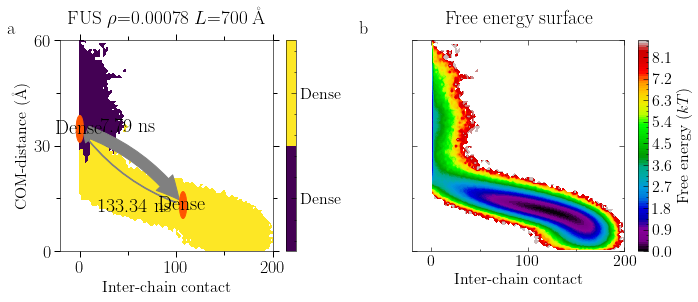

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharex=True, sharey=True)

_, _, misc = pyemma.plots.plot_state_map(
    *DataConc_select.T, bayesian_metastable_traj, ax=axes[0], zorder=-1, cbar_label=None,)
misc['cbar'].set_ticklabels(range(1, nstates+1))  

_, pos = pyemma.plots.plot_network(
    inverse_mfpt,
    #state_sizes=state_size,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.2f ns',
    arrow_labels=mfpt*0.1,
    size=20,
    arrow_curvature=3,
    state_labels=["Dense","Dense"],
    show_frame=True,
    ax=axes[0])
misc['cbar'].set_ticklabels(["Dense","Dense"])


_,_,misc=pyemma.plots.plot_free_energy(
    *DataConc_select.T,
    weights=np.concatenate(bayesian_msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
misc['cbar'].set_label(r'Free energy ($kT$)', rotation=-270)
for ax in axes.flat:
    ax.set_xlabel('Inter-chain contact')

axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Free energy surface', fontweight='bold',x=0.5, y=1.05)

axes[0].set_ylabel(r'COM-distance ($\mathrm{\AA}$)')
axes[0].set_xlabel('Inter-chain contact')
axes[0].set_xlim(-20,200)
axes[0].set_ylim(0,60)
axes[0].set_title(r"FUS $\rho$=0.00078 $L$=700 $\mathrm{\AA}$",x=0.5, y=1.05)
axes[0].set_xticks((0,100,200))
axes[0].set_yticks((0,30,60))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(2))
axes[0].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[0].tick_params(direction='out', which='major',length=6, width=1.0, labelsize=18)
axes[0].tick_params(direction='out', which='minor',length=4, width=1.0, labelsize=18)

axes[0].text(-0.25, 1.05, 'a', fontsize=18, transform=axes[0].transAxes,
      color='black',
      fontweight='bold',
      verticalalignment='center')
axes[1].text(-0.25, 1.05, 'b', fontsize=18, transform=axes[1].transAxes,
      color='black',
      fontweight='bold',
      verticalalignment='center')
fig.tight_layout()
plt.savefig('MSM_2D_2.png', dpi=600, bbox_inches='tight')

Text(0.5, 1.0, 'FUS-LC $L$=70 nm ${\\rho}$ = 0.00078')

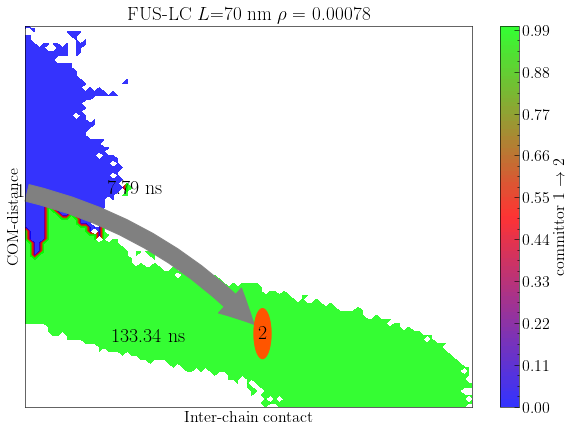

In [53]:
A_cg = bayesian_msm.metastable_sets[0]
B_cg = bayesian_msm.metastable_sets[1]
flux = pyemma.msm.tpt(bayesian_msm, A_cg, B_cg)
cg, cgflux = flux.coarse_grain(bayesian_msm.metastable_sets)
###################################
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = bayesian_msm.mfpt(
            bayesian_msm.metastable_sets[i],
            bayesian_msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]
###################################

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_contour(
    *DataConc_select.T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor 1 $\to$ 2',
    alpha=0.8,
    zorder=-1);
#inverse_mfpt is the rate and thickness; mfpt is the mean first passage time in frame-base time unit 0.1 ns

_, pos = pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    size=20,
    arrow_label_format='%.2f ns',
    arrow_curvature=3,
    arrow_labels=mfpt*0.1,
    state_sizes=cgflux.stationary_distribution,
    arrow_scale=1.5,
    state_labels=["1","2"],
    show_frame=True,
    ax=ax)


ax.set_xlabel('Inter-chain contact')
ax.set_ylabel('COM-distance')
ax.set_xlim(2,200)
ax.set_ylim(2,60)
ax.set_title("FUS-LC $L$=70 nm ${\\rho}$ = 0.00078")
#fig.tight_layout()
#plt.savefig('MSM_DDX4.png', dpi=600, bbox_inches='tight')